In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = 'resp'
ds_folder = f'/mnt/data2/chaoyue/data/cleaned_data'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_node.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_node.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [4]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_node.csv')
edge_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_edge.csv')

In [5]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000,Background,A,static,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0
1,10000,Background,A,static,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0
2,10000,Background,A,static,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0
3,10000,Background,A,static,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0
4,10000,Background,A,static,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0


In [6]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (31712630, 20)
Shape of edge data is (31704146, 5)


### Count number of trees

In [7]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 8484


In [8]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31712630 entries, 0 to 31712629
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   sim                   int64  
 1   cluster_id            object 
 2   state                 object 
 3   dynamic               object 
 4   dynamic_rparam        float64
 5   v_sampling_fraction   float64
 6   v_cluster_size        float64
 7   v_timespan            float64
 8   gamma                 float64
 9   oster                 float64
 10  PD                    float64
 11  R0                    float64
 12  abs_growth_rate       float64
 13  fraction_time_growth  float64
 14  r_max                 float64
 15  ltt_shape             object 
 16  cherries              float64
 17  BLD                   float64
 18  date                  object 
 19  node                  float64
dtypes: float64(14), int64(1), object(5)
memory usage: 4.7+ GB


In [9]:
node_df.describe()

,sim,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,node
count,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07,3.171263e+07
mean,5.021782e+03,1.989086e-05,1.399983e+03,1.506206e+03,8.274201e+01,inf,8.274704e+01,2.388844e+04,5.376305e-01,1.586121e+02,4.968839e-01,5.032668e+03,3.229767e-01,2.034686e+00,1.876295e+03
std,2.882530e+03,8.225178e-05,5.860871e+02,4.827910e+02,2.587477e+01,NaN,2.587058e+01,9.815336e+03,2.737509e+00,8.737758e+01,3.029518e-01,2.831952e+03,1.330983e-02,1.278985e+00,1.090953e+03
min,1.000000e+00,0.000000e+00,5.000563e-02,2.000000e+01,4.000000e+00,-1.347470e+05,4.088372e+00,3.200000e+01,-5.989507e+01,2.048373e-01,0.000000e+00,-1.327566e+01,1.363636e-01,-1.950000e+01,1.000000e+00
25%,2.527000e+03,0.000000e+00,1.574560e+03,1.579000e+03,8.200000e+01,-1.912734e+01,8.200381e+01,2.510100e+04,-5.600494e-01,1.134847e+02,2.307692e-01,3.624006e+03,3.190476e-01,1.500000e+00,9.350000e+02
50%,5.038000e+03,0.000000e+00,1.626400e+03,1.631000e+03,8.900000e+01,-1.725412e+01,8.900345e+01,2.762700e+04,9.357389e-01,1.597592e+02,4.923077e-01,5.152169e+03,3.234177e-01,2.000000e+00,1.869000e+03
75%,7.507000e+03,0.000000e+00,1.679520e+03,1.684000e+03,9.600000e+01,-1.374809e+01,9.600317e+01,2.930200e+04,2.186633e+00,2.089895e+02,7.600000e-01,6.718623e+03,3.276904e-01,3.000000e+00,2.804000e+03
max,1.000000e+04,8.154153e-04,1.843840e+03,4.005000e+03,1.780000e+02,inf,1.780015e+02,3.266100e+04,7.027542e+00,4.520742e+03,1.000000e+00,2.130713e+04,4.583333e-01,9.000000e+00,4.634000e+03


In [10]:
# change the dynamic of background nodes to bg
impute_node = np.where(node_df['cluster_id']=='Background')
node_df = node_df.reset_index(drop=True)
node_df.loc[(impute_node[0]),'dynamic']='bg'
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0


### Preprocessing-1: Gamma discretization
    * Quantile-based discretization function

In [11]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-1.34747044e+05 -1.91273357e+01 -1.72541238e+01 -1.37480923e+01
             inf]
{Interval(-13.748, inf, closed='right'): 0, Interval(-19.127, -17.254, closed='right'): 1, Interval(-17.254, -13.748, closed='right'): 2, Interval(-134747.04499999998, -19.127, closed='right'): 3}


In [12]:
prep_dict = {'gamma_bins':gamma_bins, 'gamma_cat_dict':gamma_cat_dict}

In [13]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0


### Preprocessing-2: Encode the categorical feature and label
#### Categorical features
    * ltt_shape
    * gamma (processed before)

In [14]:
# Use to record all the feature transformations
feat_dict = dict()

In [15]:
node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0


In [16]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'),
       CategoricalDtype(categories=[(-134747.04499999998, -19.127], (-19.127, -17.254], (-17.254, -13.748], (-13.748, inf]], ordered=True)],
      dtype=object)

In [17]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

int64 2
Index(['sim', 'gamma_cat'], dtype='object')
===
object 5
Index(['cluster_id', 'state', 'dynamic', 'ltt_shape', 'date'], dtype='object')
===
float64 14
Index(['dynamic_rparam', 'v_sampling_fraction', 'v_cluster_size', 'v_timespan',
       'gamma', 'oster', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'cherries', 'BLD', 'node'],
      dtype='object')
===
category 1
Index(['gamma_bin'], dtype='object')
===


In [18]:
# Category the ltt_shape

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}}


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3


In [19]:
# Record the cat_dict for gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['gamma'], [gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-13.748, inf, 'right')", 1: "(-19.127, -17.254, 'right')", 2: "(-17.254, -13.748, 'right')", 3: "(-134747.04499999998, -19.127, 'right')"}}


In [20]:
prep_dict['ltt_shape'] = feat_dict["ltt_shape"]
prep_dict['gamma'] = feat_dict["gamma"]

#### Categorical label
    * Convert the dynamic column to the int value

In [21]:
label_map = {'static':0,'decay':1,'growth':2,'bg':3}

In [22]:
node_df["dynamic_cat"] = node_df["dynamic"].map(label_map)
node_df["dynamic"] = node_df["dynamic"].astype('category')

In [23]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0,"(-13.748, inf]",0,3,0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0,"(-13.748, inf]",0,3,0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0,"(-13.748, inf]",0,3,0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0,"(-13.748, inf]",0,3,0


In [24]:
node_df['dynamic_cat'].unique()

array([3, 2, 0, 1])

In [25]:
node_df = node_df.reset_index(drop=True)
feat_dict['dynamic'] = {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-13.748, inf, 'right')", 1: "(-19.127, -17.254, 'right')", 2: "(-17.254, -13.748, 'right')", 3: "(-134747.04499999998, -19.127, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}}


In [26]:
prep_dict['dynamic'] = feat_dict["dynamic"]

In [27]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0,"(-13.748, inf]",0,3,0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0,"(-13.748, inf]",0,3,0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0,"(-13.748, inf]",0,3,0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0,"(-13.748, inf]",0,3,0


### Add state ID for post analysis

In [ ]:
group_dict = {}
i = 0
for group in ['Background','A','B','C','D','E','F','G']:
    group_dict[group] = i
    i += 1
group_dict

In [ ]:
node_df['state_id'] = node_df['state'].apply(lambda x: group_dict[x])

### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [29]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 9, chi2: 198056.22468254433, p_vals: 0.0
  MI: 0
gamma_cat: 
  df: 9, chi2: 7888127.146554428, p_vals: 0.0
  MI: 0


### Analysis-1
#### 1-2 The relationship between numerical features and label

In [30]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries","BLD","R0"]
aly_col = num_feat_cols + cat_feat_cols
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'R0', 'ltt_shape_cat', 'gamma_cat']
(31712630, 13) num_feat: 11, cat_feat: 2


#### 1-2-1 Pearson R

In [31]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,0.686081,0.917635,0.917625,0.980309,0.659893,0.035914,0.719467,0.062695,0.373910,0.126002,0.066339,0.547805
v_cluster_size,0.686081,1.000000,0.653436,0.653422,0.680476,0.481652,0.021158,0.501263,0.102332,0.388215,0.069568,0.046107,0.375028
v_timespan,0.917635,0.653436,1.000000,1.000000,0.918766,0.497955,0.039452,0.620356,0.090643,0.338193,0.111663,0.248876,0.503959
oster,0.917625,0.653422,1.000000,1.000000,0.918758,0.497933,0.039453,0.620343,0.090629,0.338174,0.111661,0.248895,0.503954
PD,0.980309,0.680476,0.918766,0.918758,1.000000,0.687771,0.034745,0.752024,0.088963,0.445337,0.120689,0.068489,0.576510
abs_growth_rate,0.659893,0.481652,0.497955,0.497933,0.687771,1.000000,0.008211,0.876486,0.093776,0.487093,0.025877,-0.050377,0.422216
fraction_time_growth,0.035914,0.021158,0.039452,0.039453,0.034745,0.008211,1.000000,0.034463,-0.009269,-0.022401,0.053501,0.001188,0.005203
r_max,0.719467,0.501263,0.620356,0.620343,0.752024,0.876486,0.034463,1.000000,0.079426,0.437927,0.091867,0.063797,0.452278
cherries,0.062695,0.102332,0.090643,0.090629,0.088963,0.093776,-0.009269,0.079426,1.000000,0.232793,-0.024771,-0.006195,0.058699
BLD,0.373910,0.388215,0.338193,0.338174,0.445337,0.487093,-0.022401,0.437927,0.232793,1.000000,-0.033940,-0.010740,0.296213


In [32]:
Paper_feat = ['Sampling Fraction', 'Cluster Size', 'Time Span', 'Oster', 'PD', 'Abs Growth Rate','Fraction Time Growth',r'$R_{max}$','Cherries','BLD',r'$R_0$', 'LTT Shape',r'$\gamma$']

[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

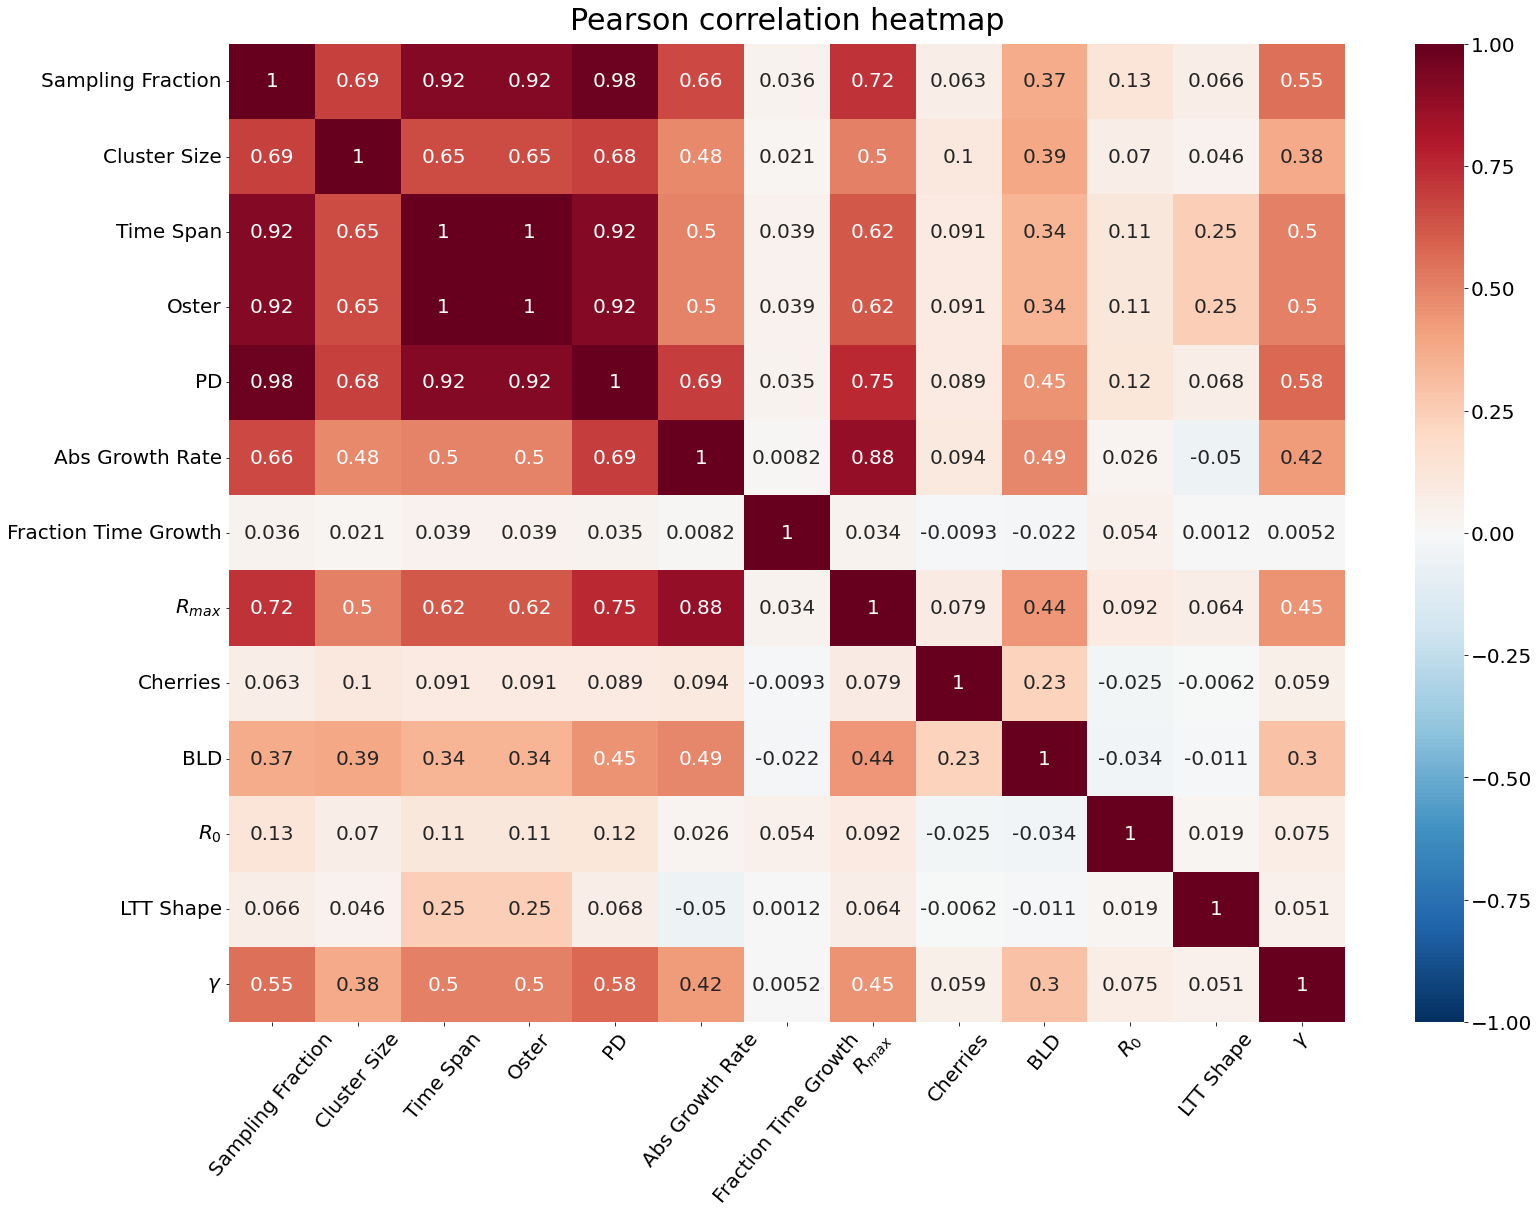

In [33]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Pearson correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/pearson.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

#### 1-2-2 Spearman correlation

In [34]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,0.866567,0.391241,0.388786,0.577098,0.400938,0.028749,0.417588,-0.014615,0.135306,0.017406,0.049223,0.371315
v_cluster_size,0.866567,1.000000,0.281702,0.279405,0.469003,0.300559,0.019687,0.308429,0.011794,0.154114,0.005948,0.037133,0.268633
v_timespan,0.391241,0.281702,1.000000,0.999622,0.516428,0.076685,0.036636,0.267033,-0.001054,0.100394,0.023042,0.469735,0.337930
oster,0.388786,0.279405,0.999622,1.000000,0.532460,0.084590,0.036682,0.274545,0.003517,0.112160,0.022567,0.465208,0.342653
PD,0.577098,0.469003,0.516428,0.532460,1.000000,0.546549,0.024375,0.597902,0.162077,0.499247,0.005424,0.057359,0.490628
abs_growth_rate,0.400938,0.300559,0.076685,0.084590,0.546549,1.000000,0.011085,0.870939,0.085102,0.468651,-0.000521,-0.065502,0.393934
fraction_time_growth,0.028749,0.019687,0.036636,0.036682,0.024375,0.011085,1.000000,0.034215,-0.003425,-0.026078,0.021596,0.001513,0.005589
r_max,0.417588,0.308429,0.267033,0.274545,0.597902,0.870939,0.034215,1.000000,0.081929,0.425547,0.019645,0.061926,0.408669
cherries,-0.014615,0.011794,-0.001054,0.003517,0.162077,0.085102,-0.003425,0.081929,1.000000,0.192196,0.002535,-0.010744,0.051859
BLD,0.135306,0.154114,0.100394,0.112160,0.499247,0.468651,-0.026078,0.425547,0.192196,1.000000,-0.015555,-0.006810,0.277266


[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

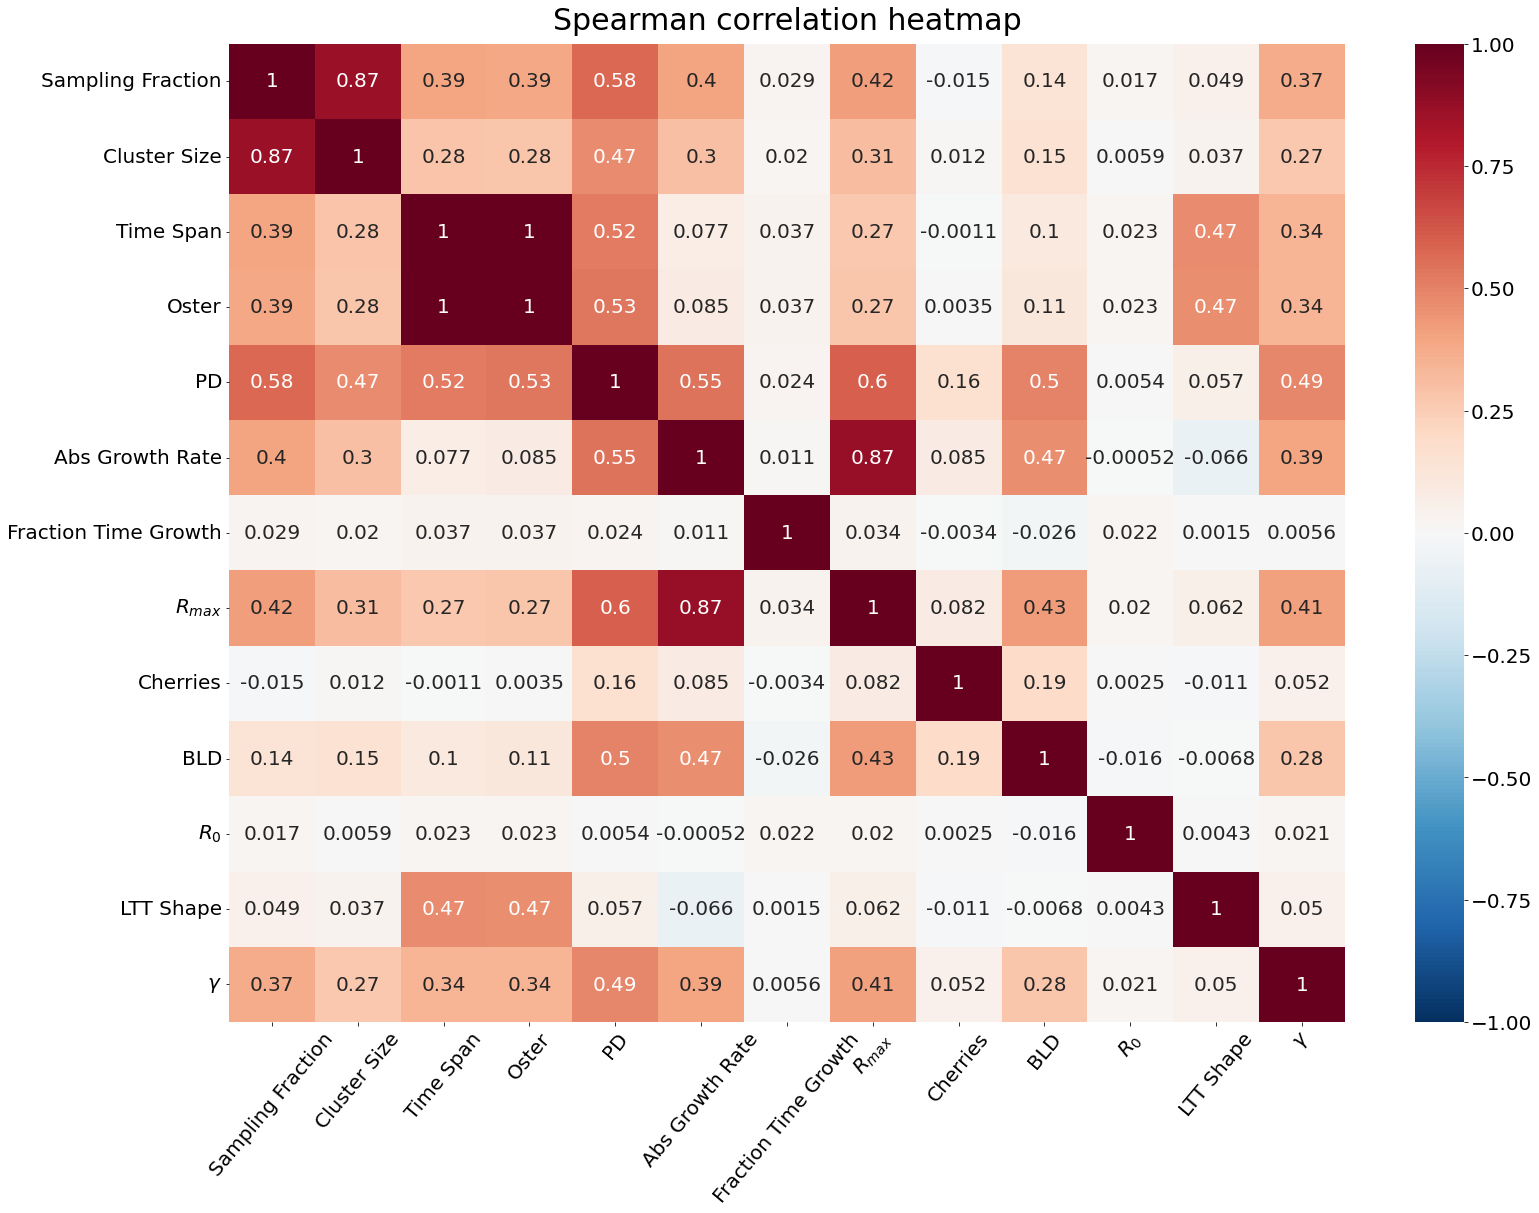

In [35]:
# Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Spearman correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/spearman.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* gamma_cat

In [36]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = ['ltt_shape_cat','gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['ltt_shape_cat', 'gamma_cat']


In [37]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [71]:
random_seed = 123
np.random.seed(random_seed)
split_dir = f'/mnt/data2/chaoyue/data/{ds_name}-classification/split_rs{random_seed}'
os.makedirs(split_dir, exist_ok=True)

In [39]:
from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 6787, Test: 1697
[8265 6760 3896 5030 8650 3934 8372 2086 4177 5260]


In [40]:

train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_node_df.shape[0]}')
print(f'Test: {test_node_df.shape[0]}')
train_node_df.head()

Train: 25362380
Test: 6350250


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,-3.419781,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Processing-2: R0 correction
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0

In [41]:
raw_r0 = np.reshape(train_node_df['R0'].values, (-1, 1))

# negtive replacement
r0_neg_idx = raw_r0 <= 0
r0_pos_idx = raw_r0 > 0
avg_r0 = np.average(raw_r0[r0_pos_idx])

raw_r0[r0_neg_idx] = avg_r0

In [42]:
prep_dict['r0'] = avg_r0

In [43]:
train_node_df['R0'].describe()

count    2.536238e+07
mean     1.862411e+00
std      9.147802e-01
min      3.031214e-04
25%      1.386609e+00
50%      1.862411e+00
75%      2.190749e+00
max      7.027542e+00
Name: R0, dtype: float64

In [44]:
r0_norm_col = 'new_R0'
train_node_df[r0_norm_col]=raw_r0
train_node_df[r0_norm_col].describe()

/home/chaoyue/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


count    2.536238e+07
mean     1.862411e+00
std      9.147802e-01
min      3.031214e-04
25%      1.386609e+00
50%      1.862411e+00
75%      2.190749e+00
max      7.027542e+00
Name: new_R0, dtype: float64

In [45]:
test_node_df['R0'].describe()

count    6.350250e+06
mean     5.197100e-01
std      2.789402e+00
min     -5.596160e+01
25%     -5.607605e-01
50%      9.284144e-01
75%      2.159936e+00
max      5.731055e+00
Name: R0, dtype: float64

In [46]:
raw_r0 = np.reshape(test_node_df['R0'].values, (-1, 1))
r0_neg_idx = raw_r0 <= 0
raw_r0[r0_neg_idx] = avg_r0

In [47]:
r0_norm_col = 'new_R0'
test_node_df[r0_norm_col]=raw_r0
test_node_df[r0_norm_col].describe()

count    6.350250e+06
mean     1.852876e+00
std      9.402563e-01
min      7.341353e-04
25%      1.324267e+00
50%      1.862411e+00
75%      2.159936e+00
max      5.731055e+00
Name: new_R0, dtype: float64

In [48]:
num_feat_cols[-1] = 'new_R0'

### Processing-3. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

array([[<AxesSubplot:title={'center':'v_sampling_fraction'}>,
        <AxesSubplot:title={'center':'v_cluster_size'}>,
        <AxesSubplot:title={'center':'v_timespan'}>],
       [<AxesSubplot:title={'center':'oster'}>,
        <AxesSubplot:title={'center':'PD'}>,
        <AxesSubplot:title={'center':'abs_growth_rate'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth'}>,
        <AxesSubplot:title={'center':'r_max'}>,
        <AxesSubplot:title={'center':'cherries'}>],
       [<AxesSubplot:title={'center':'BLD'}>,
        <AxesSubplot:title={'center':'new_R0'}>, <AxesSubplot:>]],
      dtype=object)

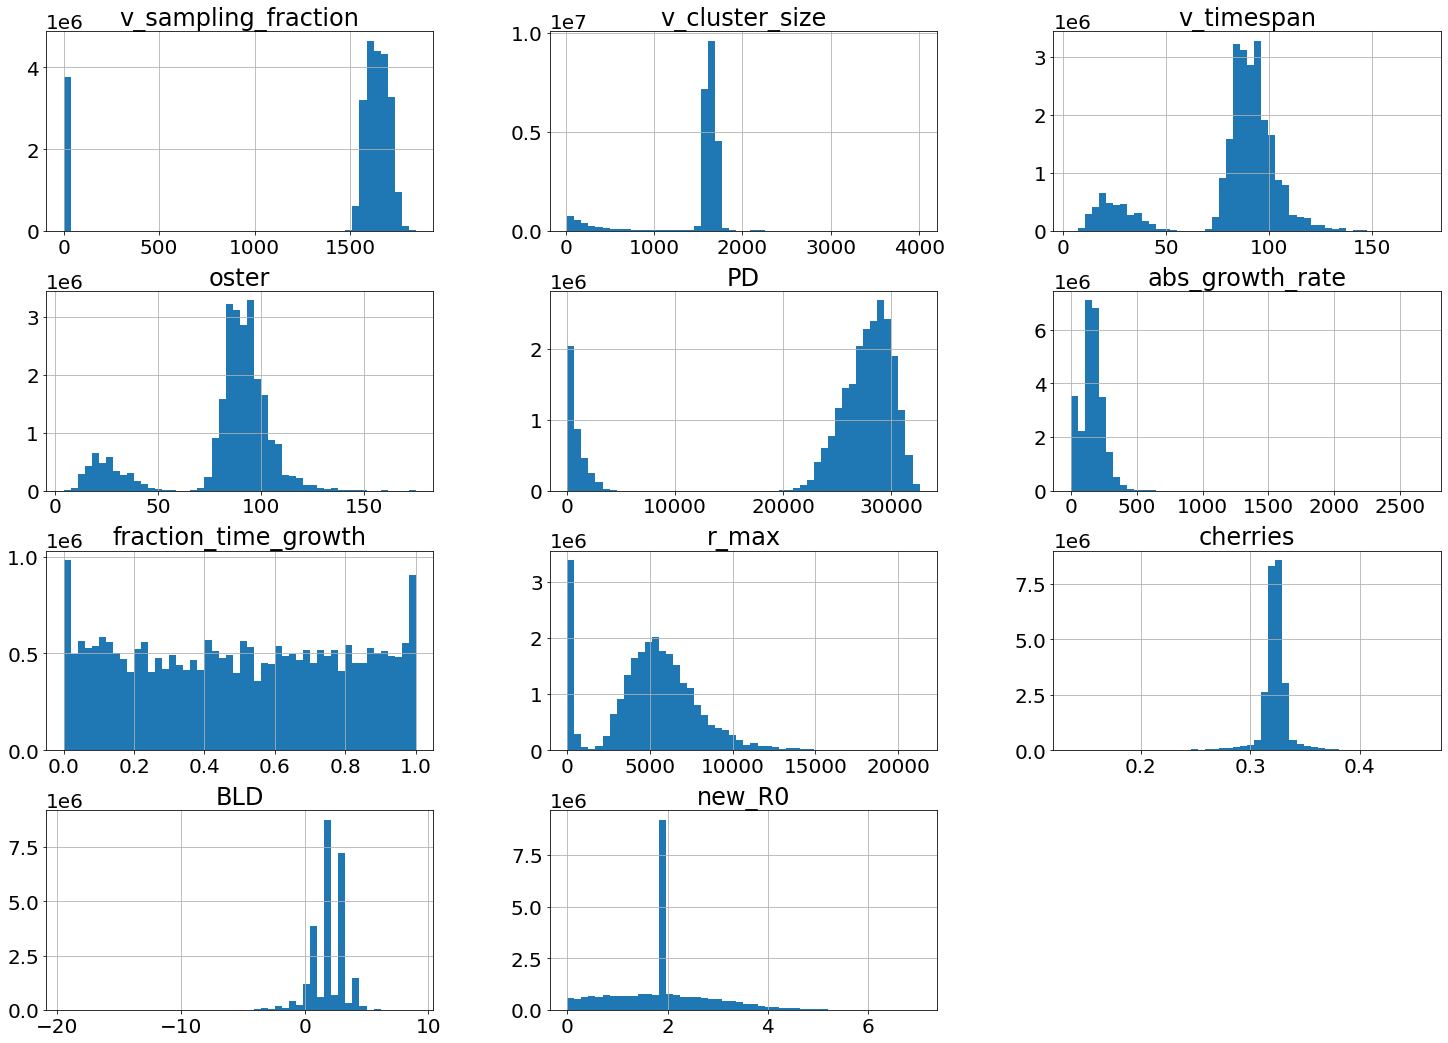

In [49]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(25, 18))

In [50]:
num_feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0']

In [51]:
cat_feat_cols

['ltt_shape_cat', 'gamma_cat']

In [52]:
feat_cols = num_feat_cols+cat_feat_cols
feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0',
 'ltt_shape_cat',
 'gamma_cat']

In [53]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

In [54]:
norm_train_vals

array([[ 5.25075525e-01,  4.19000804e-01,  5.10329823e-01, ...,
         1.53040411e-01,  7.52055034e-01, -1.94184006e-15],
       [ 5.25075525e-01,  4.19000804e-01,  5.10329823e-01, ...,
         1.53040411e-01,  7.52055034e-01, -1.94184006e-15],
       [ 5.25075525e-01,  4.19000804e-01,  5.10329823e-01, ...,
         1.53040411e-01,  7.52055034e-01, -1.94184006e-15],
       ...,
       [-2.38929895e+00, -2.99840682e+00, -2.00176736e+00, ...,
        -2.20805135e-01, -2.00161351e+00, -1.43417758e+00],
       [-2.38929895e+00, -2.99840682e+00, -2.00176736e+00, ...,
        -2.20805135e-01, -2.00161351e+00, -1.43417758e+00],
       [-2.38929895e+00, -2.99840682e+00, -2.00176736e+00, ...,
        -2.20805135e-01, -2.00161351e+00, -1.43417758e+00]])

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

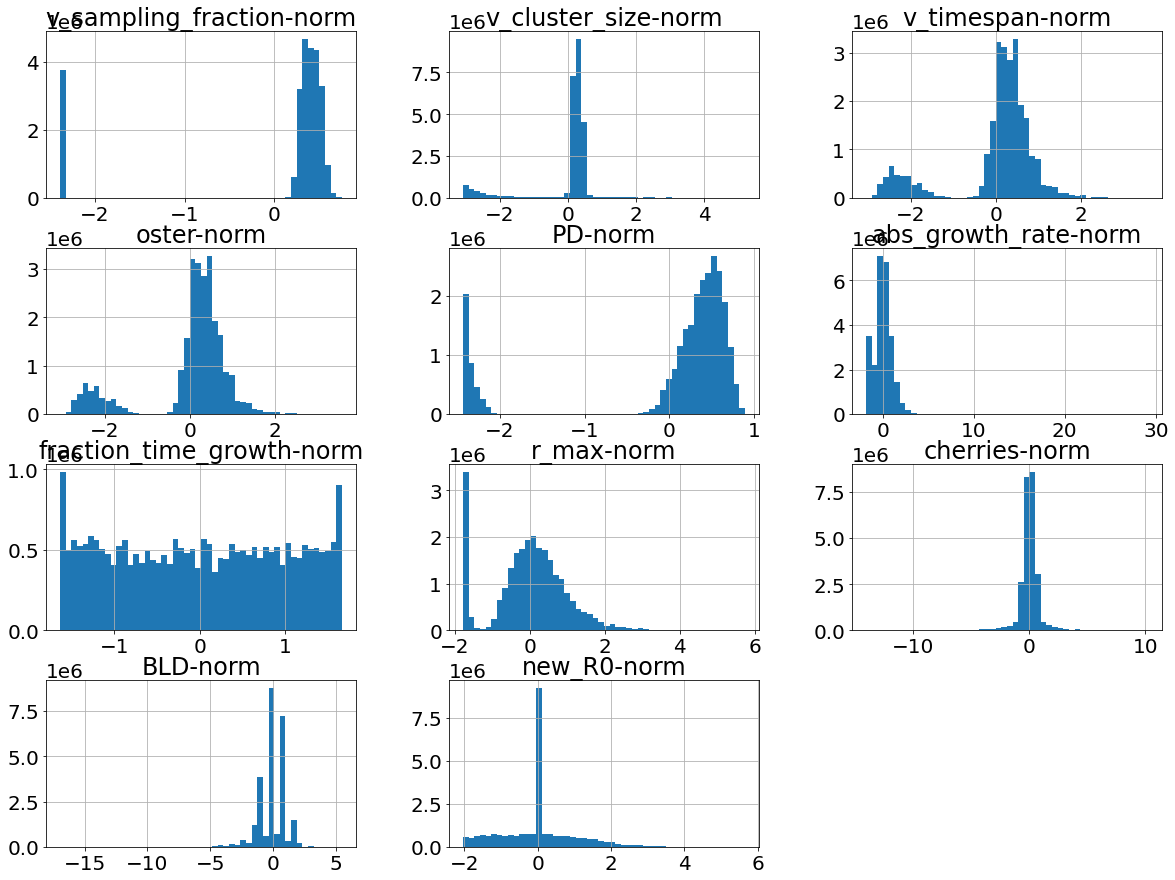

In [55]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [56]:
print(std_scaler.mean_, std_scaler.scale_)

[1.40010988e+03 1.50531018e+03 8.27953204e+01 8.28003460e+01
 2.39152783e+04 1.58456570e+02 4.95996744e-01 5.04373453e+03
 3.22927270e-01 2.04411422e+00 1.86241069e+00] [5.85763574e+02 4.81359025e+02 2.58747952e+01 2.58706018e+01
 9.81932300e+03 8.65407592e+01 3.03586950e-01 2.83566164e+03
 1.32572557e-02 1.27103169e+00 9.14780201e-01]


In [57]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

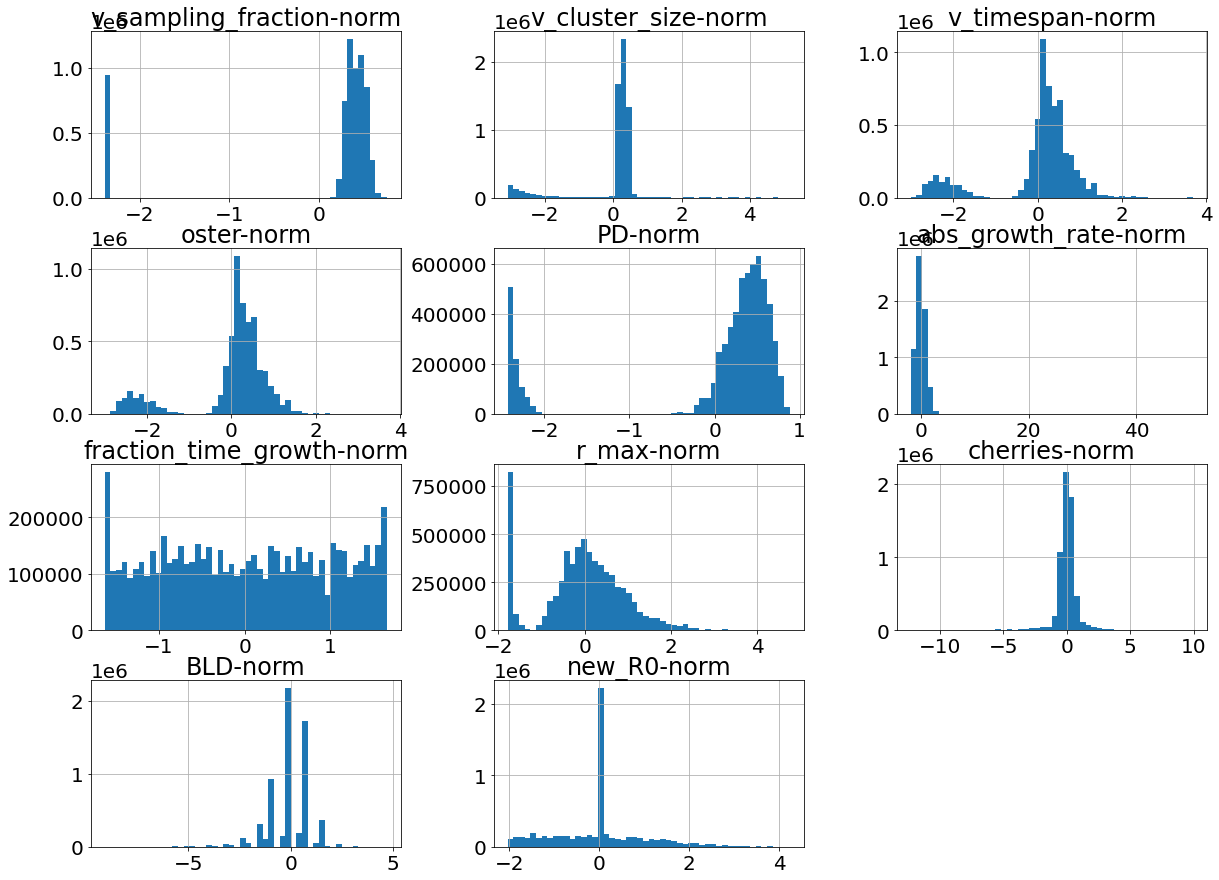

In [58]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [59]:
train_node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,1.862411,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.510330,0.510340,0.646859,0.455480,1.239657,0.063349,0.153040,0.752055,-1.941840e-15
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,1.862411,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.510330,0.510340,0.646859,0.455480,1.239657,0.063349,0.153040,0.752055,-1.941840e-15
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,1.862411,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.510330,0.510340,0.646859,0.455480,1.239657,0.063349,0.153040,0.752055,-1.941840e-15
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,1.862411,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.510330,0.510340,0.646859,0.455480,1.239657,0.063349,0.153040,0.752055,-1.941840e-15
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,1.862411,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.510330,0.510340,0.646859,0.455480,1.239657,0.063349,0.153040,0.752055,-1.941840e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178e+00
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178e+00
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178e+00
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178e+00


In [60]:
num_feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0']

In [61]:
prep_dict['feat'] = num_feat_cols
prep_dict['mean'] = std_scaler.mean_
prep_dict['std'] = std_scaler.scale_
prep_dict

{'gamma_bins': array([-1.34747044e+05, -1.91273357e+01, -1.72541238e+01, -1.37480923e+01,
                    inf]),
 'gamma_cat_dict': {Interval(-13.748, inf, closed='right'): 0,
  Interval(-19.127, -17.254, closed='right'): 1,
  Interval(-17.254, -13.748, closed='right'): 2,
  Interval(-134747.04499999998, -19.127, closed='right'): 3},
 'ltt_shape': {0: 'concave',
  1: 'concave_convex',
  2: 'convex',
  3: 'convex_concave'},
 'gamma': {0: "(-13.748, inf, 'right')",
  1: "(-19.127, -17.254, 'right')",
  2: "(-17.254, -13.748, 'right')",
  3: "(-134747.04499999998, -19.127, 'right')"},
 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'},
 'r0': 1.8624106912754312,
 'feat': ['v_sampling_fraction',
  'v_cluster_size',
  'v_timespan',
  'oster',
  'PD',
  'abs_growth_rate',
  'fraction_time_growth',
  'r_max',
  'cherries',
  'BLD',
  'new_R0'],
 'mean': array([1.40010988e+03, 1.50531018e+03, 8.27953204e+01, 8.28003460e+01,
        2.39152783e+04, 1.58456570e+02, 4.95996744e-01, 5

In [62]:
np.save("prep-resp.npy",prep_dict)

#### Plot for Paper Supplementary(not included in preprocessing) 

In [89]:
# remove samples with AbsGrowth Rate>100
train_node_df = train_node_df[train_node_df[feat_cols[5]]<100]
test_node_df = test_node_df[test_node_df[feat_cols[5]]<100]

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


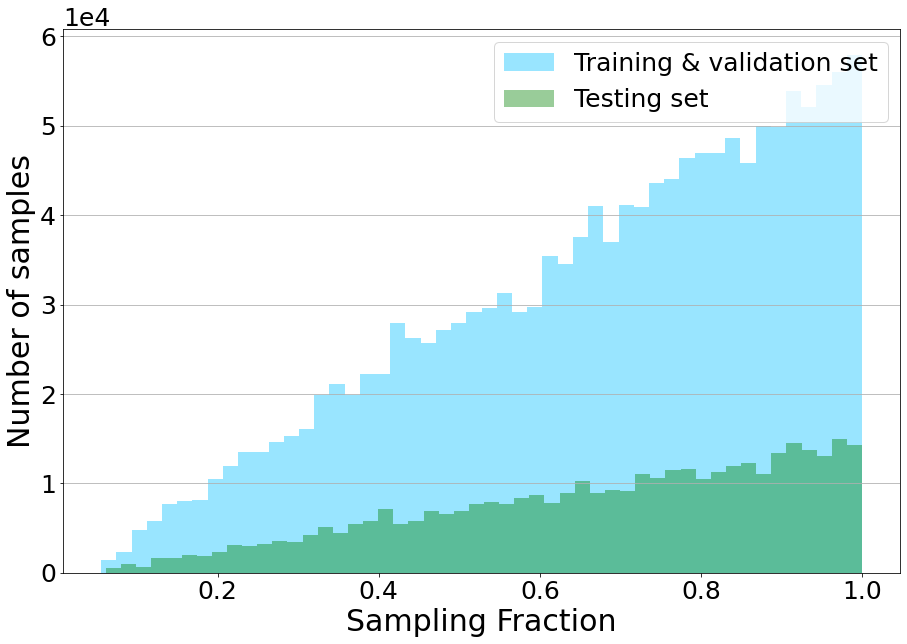

In [90]:
i = 0
feat = feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,700000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
#ax1.axes.set_xlabel(f"{Paper_feat[i]} category",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

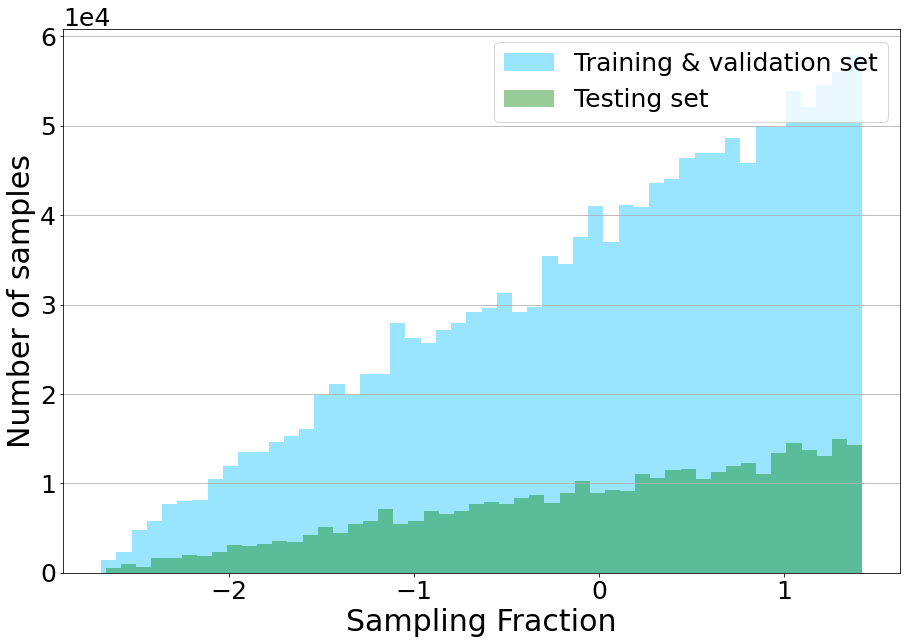

In [91]:
i = 0
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

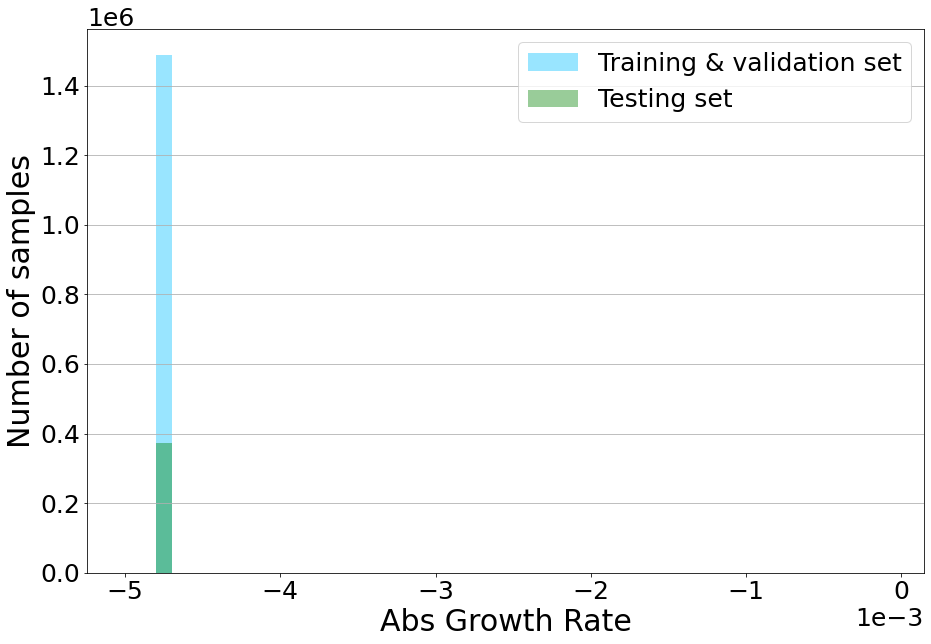

In [92]:
# special for AbsGrowthRate
i = 5
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

In [63]:
# Obtain the onehot features
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-13.748, inf, 'right')", 1: "(-19.127, -17.254, 'right')", 2: "(-17.254, -13.748, 'right')", 3: "(-134747.04499999998, -19.127, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [64]:
print(train_node_df.shape)

(25362380, 44)


In [65]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15


In [66]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15


### Merge the background and non-background nodes

In [67]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
#train_full_df = train_node_df
#print(f'Train: {train_full_df.shape}')

#test_full_df = test_node_df
#print(f'Test: {test_full_df.shape}')

train_full_df = train_node_df
print(f'Train: {train_full_df.shape}')

test_full_df = test_node_df
print(f'Test: {test_full_df.shape}')

Train: (25362380, 44)
Test: (6350250, 44)


#### Split validation set

In [68]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Test: {len(valid_ids)}")
print(valid_ids[:10])

Train: 5090, Test: 1697
[4659 8505 8480 3392 9836 4275 9881 6081 2370 3423]


In [69]:
train_full_df = train_full_df.reset_index(drop=True)
train_node_df = train_full_df[train_full_df['sim'].isin(train_ids)]
valid_node_df = train_full_df[train_full_df['sim'].isin(valid_ids)]

print(f'Train node: {train_node_df.shape[0]}')
print(f'Valid node: {valid_node_df.shape[0]}')
train_node_df.head()

Train node: 19021665
Valid node: 6340715


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15


In [72]:
# Save the train/valid/test to the disk
train_node_df.to_csv(f'{split_dir}/train.csv', index=False)
test_full_df.to_csv(f'{split_dir}/test.csv', index=False)
valid_node_df.to_csv(f'{split_dir}/valid.csv', index=False)

In [73]:
train_full_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
1,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
2,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
3,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15
4,10000,Background,A,bg,0.0,1707.68,1707.0,96.0,457.476318,96.00315,30267.0,1.862411,197.874194,0.87234,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0,"(-13.748, inf]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.862411,0.525076,0.419001,0.51033,0.51034,0.646859,0.45548,1.239657,0.063349,0.15304,0.752055,-1.941840e-15


In [74]:
train_full_df.tail()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
25362375,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.32,-0.5,2020-04-04,530.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178
25362376,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.32,-0.5,2020-04-04,1887.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178
25362377,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.32,-0.5,2020-04-02,2155.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178
25362378,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.32,-0.5,2020-03-30,2154.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178
25362379,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.32,-0.5,2020-04-04,1722.0,"(-13.748, inf]",0,3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.550453,-2.389299,-2.998407,-2.001767,-2.001883,-2.408748,-1.813314,-0.755402,-1.773388,-0.220805,-2.001614,-1.434178


### Finalize the feature information and save to the file

In [75]:
all_cols = test_full_df.columns
print(all_cols)

Index(['sim', 'cluster_id', 'state', 'dynamic', 'dynamic_rparam',
       'v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth', 'r_max',
       'ltt_shape', 'cherries', 'BLD', 'date', 'node', 'gamma_bin',
       'gamma_cat', 'ltt_shape_cat', 'dynamic_cat', 'ltt_shape_cat_0',
       'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0',
       'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3', 'new_R0',
       'v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm',
       'oster-norm', 'PD-norm', 'abs_growth_rate-norm',
       'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm',
       'new_R0-norm'],
      dtype='object')


In [76]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols[3:]}', len(norm_onehot_cols[3:]))

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'new_R0', 'ltt_shape_cat', 'gamma_cat'] 13
Norm with onehot cols: ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 16


In [77]:
feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols[3:]

In [78]:
import json 

with open('feat_dict-resp.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)